In [1]:
import os
import io
import zipfile
import requests
import geopandas as gpd
import rasterio
from rasterio.mask import mask

# Working dirs
SCRIPT_DIR = os.getcwd()  # or set to your project path
DATA_DIR   = os.path.join(SCRIPT_DIR, "data")
GADM_DIR   = os.path.join(SCRIPT_DIR, "gadm_germany")
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(GADM_DIR, exist_ok=True)

print(SCRIPT_DIR)


C:\Users\chris\Projekte\JazztageLabor\Deforestation\notebooks\Saxony\Points_Lines_planes


In [2]:
# GADM 4.1 (Germany, level 1 = states)
gadm_zip_url = "https://geodata.ucdavis.edu/gadm/gadm4.1/shp/gadm41_DEU_shp.zip"

# Download & extract if needed
gadm_zip_path = os.path.join(GADM_DIR, "gadm41_DEU_shp.zip")
if not os.path.exists(os.path.join(GADM_DIR, "gadm41_DEU_1.shp")):
    if not os.path.exists(gadm_zip_path):
        r = requests.get(gadm_zip_url, timeout=120)
        r.raise_for_status()
        with open(gadm_zip_path, "wb") as f:
            f.write(r.content)
    with zipfile.ZipFile(gadm_zip_path) as z:
        z.extractall(GADM_DIR)

# Read states and select Saxony (Sachsen)
gdf_states = gpd.read_file(os.path.join(GADM_DIR, "gadm41_DEU_1.shp"))
saxony = gdf_states[gdf_states["NAME_1"] == "Sachsen"].copy()
assert len(saxony) == 1, "Could not uniquely select Saxony."

saxony = saxony.to_crs("EPSG:4326")  # keep in WGS84 for now
saxony.head()


,GID_1,GID_0,COUNTRY,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,ISO_1,geometry
12,DEU.14_1,DEU,Germany,Sachsen,Saxony,NA,Freistaat,State,14,DE.SN,DE-SN,"POLYGON ((12.35469 50.24796, 12.35507 50.24726..."


In [3]:
# Hansen GFC 2024 v1.12 lossyear tile that covers Saxony
HANSEN_BASE = "https://storage.googleapis.com/earthenginepartners-hansen/GFC-2024-v1.12"
TILE_TAG    = "60N_010E"  # covers 60–50N, 10–20E (Saxony ~51N, 12–15E)
LOSS_TILE   = f"Hansen_GFC-2024-v1.12_lossyear_{TILE_TAG}.tif"

loss_src_path = os.path.join(DATA_DIR, LOSS_TILE)
if not os.path.exists(loss_src_path):
    url = f"{HANSEN_BASE}/{LOSS_TILE}"
    print("Downloading:", url)
    r = requests.get(url, stream=True, timeout=600)
    r.raise_for_status()
    with open(loss_src_path, "wb") as f:
        for chunk in r.iter_content(chunk_size=1024*1024):
            if chunk:
                f.write(chunk)
else:
    print("Already downloaded:", loss_src_path)

loss_src_path

TREE_TILE = f"Hansen_GFC-2024-v1.12_treecover2000_{TILE_TAG}.tif"
tree_src_path = os.path.join(DATA_DIR, TREE_TILE)
if not os.path.exists(tree_src_path):
    url = f"{HANSEN_BASE}/{TREE_TILE}"
    print("Downloading:", url)
    r = requests.get(url, stream=True, timeout=600)
    r.raise_for_status()
    with open(tree_src_path, "wb") as f:
        for chunk in r.iter_content(chunk_size=1024*1024):
            if chunk:
                f.write(chunk)


Already downloaded: C:\Users\chris\Projekte\JazztageLabor\Deforestation\notebooks\Saxony\Points_Lines_planes\data\Hansen_GFC-2024-v1.12_lossyear_60N_010E.tif


In [4]:
from rasterio.mask import mask

def clip_raster_to_boundary(input_tif, boundary_gdf, output_tif):
    with rasterio.open(input_tif) as src:
        # Match CRS
        boundary_proj = boundary_gdf.to_crs(src.crs)

        # Clip (crop=True to trim extent)
        out_image, out_transform = mask(
            src, 
            boundary_proj.geometry, 
            crop=True, 
            all_touched=False,  # keep strict boundaries for categorical rasters
            nodata=0
        )
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width":  out_image.shape[2],
            "transform": out_transform,
            "nodata": 0
        })

    with rasterio.open(output_tif, "w", **out_meta) as dest:
        dest.write(out_image)

    return output_tif

loss_out_path = os.path.join(SCRIPT_DIR, "hansen_lossyear_saxony.tif")
_ = clip_raster_to_boundary(loss_src_path, saxony, loss_out_path)
print("Saved:", loss_out_path)


Saved: C:\Users\chris\Projekte\JazztageLabor\Deforestation\notebooks\Saxony\Points_Lines_planes\hansen_lossyear_saxony.tif


In [5]:
import numpy as np
import rasterio

with rasterio.open(loss_out_path) as src:
    arr = src.read(1)
    crs = src.crs
    res = src.res
    unique_vals = np.unique(arr)
    print("CRS:", crs)
    print("Resolution (x, y):", res)
    print("Unique sample values (first 20):", unique_vals[:20])
    print("Min/Max:", arr.min(), arr.max())

# Note: Hansen lossyear codes
# 0 = no loss
# 1..24 = loss in 2001..2024


CRS: EPSG:4326
Resolution (x, y): (0.00025, 0.00025)
Unique sample values (first 20): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Min/Max: 0 24


In [6]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

def reproject_categorical(src_path, dst_epsg=25833):
    base, ext = os.path.splitext(src_path)
    dst_path = f"{base}_EPSG{dst_epsg}{ext}"

    with rasterio.open(src_path) as src:
        if src.crs and src.crs.to_epsg() == dst_epsg:
            return src_path  # already in desired CRS

        dst_crs = rasterio.crs.CRS.from_epsg(dst_epsg)
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds
        )

        kwargs = src.meta.copy()
        kwargs.update({
            "crs": dst_crs,
            "transform": transform,
            "width": width,
            "height": height
        })

        with rasterio.open(dst_path, "w", **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest  # keep discrete lossyear codes
                )
    return dst_path

loss_out_metric = reproject_categorical(loss_out_path, dst_epsg=25833)
print("Metric raster:", loss_out_metric)


Metric raster: C:\Users\chris\Projekte\JazztageLabor\Deforestation\notebooks\Saxony\Points_Lines_planes\hansen_lossyear_saxony_EPSG25833.tif


In [7]:
# !pip install geopandas shapely scikit-image scikit-learn rasterio

import os
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.transform import xy
from shapely.geometry import Point
from skimage.measure import label, regionprops
from sklearn.neighbors import NearestNeighbors

SCRIPT_DIR = os.getcwd()
LOSS_TIF = os.path.join(SCRIPT_DIR, "hansen_lossyear_saxony.tif")

def reproject_to_metric(src_path, dst_path=None, dst_epsg=25833):
    """
    Reproject categorical raster to a metric CRS (meters) with nearest-neighbor resampling.
    Default: ETRS89 / UTM 33N (EPSG:25833), good for Saxony.
    Returns path to metric raster (dst_path or src_path if already projected).
    """
    with rasterio.open(src_path) as src:
        if src.crs and src.crs.is_projected:
            return src_path  # already metric

        if dst_path is None:
            base, ext = os.path.splitext(src_path)
            dst_path = base + f"_EPSG{dst_epsg}" + ext

        dst_crs = rasterio.crs.CRS.from_epsg(dst_epsg)
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds
        )
        kwargs = src.meta.copy()
        kwargs.update({"crs": dst_crs, "transform": transform, "width": width, "height": height})

        with rasterio.open(dst_path, "w", **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest,  # keep discrete classes!
                )
    return dst_path

METRIC_TIF = reproject_to_metric(LOSS_TIF)  # no-op if already projected
METRIC_TIF


'C:\\Users\\chris\\Projekte\\JazztageLabor\\Deforestation\\notebooks\\Saxony\\Points_Lines_planes\\hansen_lossyear_saxony_EPSG25833.tif'

In [13]:
def compute_cluster_features_for_year(
    lossyear_tif,
    year,
    connectivity=2,   # 1=4-connected, 2=8-connected (recommended)
    min_pixels=4      # sieve tiny specks (< 4 px by default)
):
    """
    Returns (gdf_clusters, summary_dict).
    gdf_clusters columns include:
      - n_pixels, area_ha, perimeter_m
      - elongation (major/minor), circularity (4πA/P^2), solidity
      - length_m (major axis), width_m ≈ area / length
      - centroid (geometry), nn_dist_m (nearest neighbor centroid distance)
    """
    with rasterio.open(lossyear_tif) as src:
        arr = src.read(1)
        tr  = src.transform
        crs = src.crs
        res_x, res_y = src.res
        pixel_area_m2 = abs(res_x * res_y)
        # perimeter conversion factor (pixels->meters); rough but fine for classification
        pix2m = np.mean([abs(res_x), abs(res_y)])

    # Mask for the requested year (Hansen lossyear codes: 1..24 => 2001..2024)
    target_code = int(year - 2000)
    if target_code < 1 or target_code > 24:
        raise ValueError("Year must be within 2001..2024 for Hansen GFC 2024 v1.12.")
    mask = (arr == target_code)
    if not np.any(mask):
        # return empty structures but with a summary
        empty_gdf = gpd.GeoDataFrame(columns=[
            "cluster_id","year","n_pixels","area_m2","area_ha","perimeter_m",
            "circularity","solidity","elongation","length_m","width_m",
            "nn_dist_m","geometry"
        ], geometry="geometry", crs=crs)
        return empty_gdf, {"year": year, "n_patches": 0, "total_area_ha": 0.0}

    # Label clusters
    lab = label(mask.astype(np.uint8), connectivity=connectivity)

    # Remove tiny clusters
    vals, counts = np.unique(lab[lab > 0], return_counts=True)
    keep = set(vals[counts >= min_pixels])
    lab[~np.isin(lab, list(keep))] = 0
    n_clusters = int(np.max(lab))
    if n_clusters == 0:
        empty_gdf = gpd.GeoDataFrame(columns=[
            "cluster_id","year","n_pixels","area_m2","area_ha","perimeter_m",
            "circularity","solidity","elongation","length_m","width_m",
            "nn_dist_m","geometry"
        ], geometry="geometry", crs=crs)
        return empty_gdf, {"year": year, "n_patches": 0, "total_area_ha": 0.0}

    props = regionprops(lab)
    recs = []
    cents = []

    for rp in props:
        pid = rp.label
        npx = int(rp.area)

        # core geometry
        perim_px = float(rp.perimeter)
        area_m2  = npx * pixel_area_m2
        area_ha  = area_m2 / 10000.0
        perim_m  = perim_px * pix2m

        # shape metrics
        circularity = (4.0 * np.pi * npx) / (perim_px ** 2) if perim_px > 0 else np.nan
        solidity    = float(getattr(rp, "solidity", np.nan))
        maj = float(getattr(rp, "major_axis_length", np.nan))
        minr = float(getattr(rp, "minor_axis_length", np.nan))
        elongation = (maj / minr) if (minr and minr > 0) else np.nan
        length_m   = maj * pix2m if maj and maj > 0 else np.nan
        width_m    = (area_m2 / length_m) if (length_m and length_m > 0) else np.nan

        # centroid
        r, c = rp.centroid
        cx, cy = xy(tr, r, c, offset='center')
        cents.append((cx, cy))

        recs.append({
            "cluster_id": pid,
            "year": year,
            "n_pixels": npx,
            "area_m2": area_m2,
            "area_ha": area_ha,
            "perimeter_m": perim_m,
            "circularity": circularity,
            "solidity": solidity,
            "elongation": elongation,
            "length_m": length_m,
            "width_m": width_m,
        })

    gdf = gpd.GeoDataFrame(recs, geometry=[Point(xy) for xy in cents], crs=crs)

    # nearest-neighbor distances between centroids
    if len(gdf) > 1:
        X = np.c_[gdf.geometry.x.values, gdf.geometry.y.values]
        nn = NearestNeighbors(n_neighbors=2).fit(X)
        dists, _ = nn.kneighbors(X)
        gdf["nn_dist_m"] = dists[:, 1]
    else:
        gdf["nn_dist_m"] = np.nan

    summary = {
        "year": year,
        "n_patches": int(len(gdf)),
        "total_area_ha": float(gdf["area_ha"].sum()),
        "median_area_ha": float(gdf["area_ha"].median()) if len(gdf) else 0.0,
        "median_elongation": float(gdf["elongation"].median()) if len(gdf) else np.nan,
        "median_circularity": float(gdf["circularity"].median()) if len(gdf) else np.nan,
    }
    return gdf, summary


In [9]:
# Default thresholds — tweak to taste or tune per-year by quantiles
CLASS_PARAMS = dict(
    point_area_ha_max = 0.36,   # ~4 pixels @ 30m (~0.09 ha/px) -> "small"
    point_nn_min_m    = 300.0,  # "isolated" in meters

    line_elong_min    = 3.0,    # at least 3:1
    line_width_max_m  = 60.0,   # <= ~2 pixels wide
    line_circ_max     = 0.20,   # circularity low for stringy shapes

    plane_area_min_ha = 1.0,    # larger blobs
    plane_elong_max   = 2.0,    # not too elongated
    plane_circ_min    = 0.40    # reasonably compact
)

def classify_shape(row, P=CLASS_PARAMS):
    # Guard against NaNs
    area = row.get("area_ha", np.nan)
    nn   = row.get("nn_dist_m", np.nan)
    elong= row.get("elongation", np.nan)
    width= row.get("width_m", np.nan)
    circ = row.get("circularity", np.nan)

    # POINT
    if (pd.notna(area) and pd.notna(nn)
        and area <= P["point_area_ha_max"]
        and nn >= P["point_nn_min_m"]):
        return "point"

    # LINE
    if (pd.notna(elong) and pd.notna(width) and pd.notna(circ)
        and elong >= P["line_elong_min"]
        and width <= P["line_width_max_m"]
        and circ <= P["line_circ_max"]):
        return "line"

    # PLANE
    if (pd.notna(area) and pd.notna(elong) and pd.notna(circ)
        and area >= P["plane_area_min_ha"]
        and elong <= P["plane_elong_max"]
        and circ >= P["plane_circ_min"]):
        return "plane"

    return "other"


In [10]:
YEARS = list(range(2001, 2025))  # adjust if needed

all_gdfs = []
summaries = []

for y in YEARS:
    gdf_y, summ_y = compute_cluster_features_for_year(METRIC_TIF, y, connectivity=2, min_pixels=4)
    if not gdf_y.empty:
        gdf_y["shape_class"] = gdf_y.apply(classify_shape, axis=1)
        # Add normalized features (0..1) for musical mapping, per-year (optional)
        for col in ["area_ha","elongation","width_m","nn_dist_m","circularity"]:
            if col in gdf_y.columns:
                s = gdf_y[col].astype(float)
                rng = (s.max() - s.min())
                gdf_y[col + "_norm01"] = (s - s.min()) / rng if rng and rng > 0 else 0.0
    all_gdfs.append(gdf_y)
    summaries.append(summ_y)

clusters = pd.concat(all_gdfs, ignore_index=True) if len(all_gdfs) else gpd.GeoDataFrame()
summary_df = pd.DataFrame(summaries)

print("Per-year summaries:")
display(summary_df.head())

# Exports
out_gpkg = os.path.join(SCRIPT_DIR, "loss_clusters_all_years.gpkg")
out_csv  = os.path.join(SCRIPT_DIR, "loss_clusters_all_years.csv")
out_sum  = os.path.join(SCRIPT_DIR, "loss_clusters_summary_by_year.csv")

if not clusters.empty:
    gpd.GeoDataFrame(clusters, geometry="geometry", crs=clusters.crs).to_file(
        out_gpkg, layer="clusters", driver="GPKG"
    )
    clusters.drop(columns="geometry").to_csv(out_csv, index=False)
summary_df.to_csv(out_sum, index=False)

print(f"Saved:\n- {out_gpkg}\n- {out_csv}\n- {out_sum}")


Per-year summaries:


,year,n_patches,total_area_ha,median_area_ha,median_elongation,median_circularity
0,2001,1142,552.713346,0.276396,1.632993,2.094395
1,2002,1379,702.283153,0.236911,1.632993,2.094395
2,2003,236,149.648777,0.276396,1.732051,2.094395
3,2004,2034,1159.876736,0.276396,1.632993,2.094395
4,2005,1619,995.618448,0.315881,1.681439,2.094395


Saved:
- C:\Users\chris\Projekte\JazztageLabor\Deforestation\notebooks\Saxony\Points_Lines_planes\loss_clusters_all_years.gpkg
- C:\Users\chris\Projekte\JazztageLabor\Deforestation\notebooks\Saxony\Points_Lines_planes\loss_clusters_all_years.csv
- C:\Users\chris\Projekte\JazztageLabor\Deforestation\notebooks\Saxony\Points_Lines_planes\loss_clusters_summary_by_year.csv


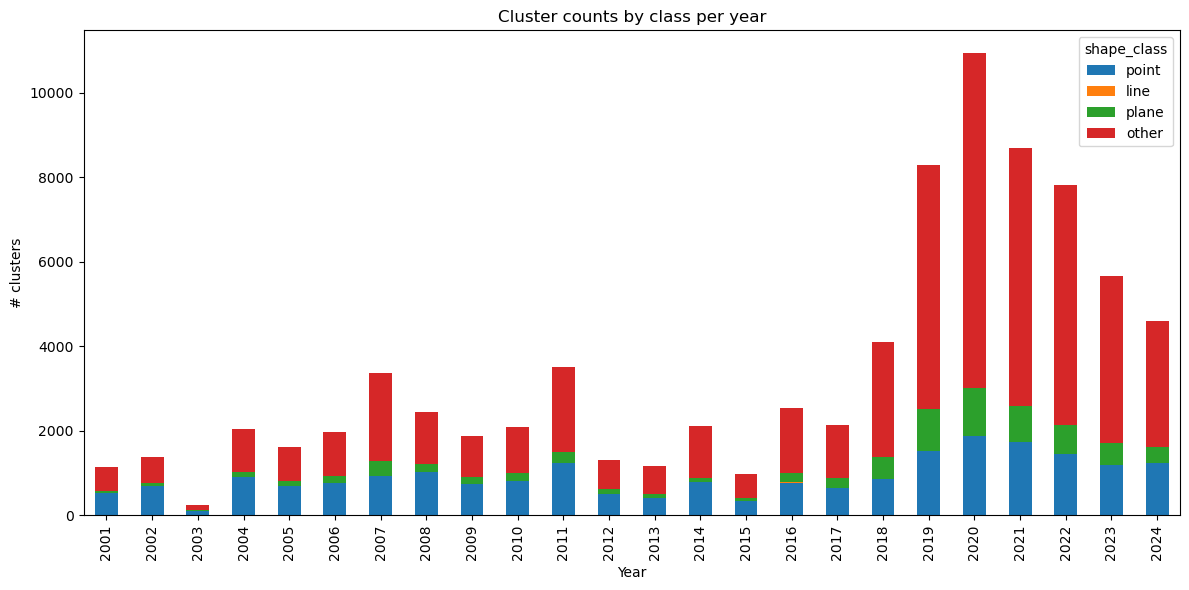

In [12]:
import matplotlib.pyplot as plt

if not clusters.empty:
    counts = (clusters.groupby(["year","shape_class"])
                      .size()
                      .reset_index(name="n"))
    classes = ["point","line","plane","other"]
    counts["shape_class"] = pd.Categorical(counts["shape_class"], classes, ordered=True)
    counts = counts.sort_values(["year","shape_class"])

    pivot = counts.pivot(index="year", columns="shape_class", values="n").fillna(0)

    plt.figure(figsize=(12,6))
    pivot[classes].plot(kind="bar", stacked=True, ax=plt.gca())
    plt.title("Cluster counts by class per year")
    plt.ylabel("# clusters")
    plt.xlabel("Year")
    plt.tight_layout()
    plt.savefig("cluster_count_by_class_per_year.png", dpi=300, bbox_inches="tight") 
    plt.show()


C:\Users\chris\AppData\Local\Temp\ipykernel_32824\2286225113.py:12: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geom = saxony_m.geometry.unary_union


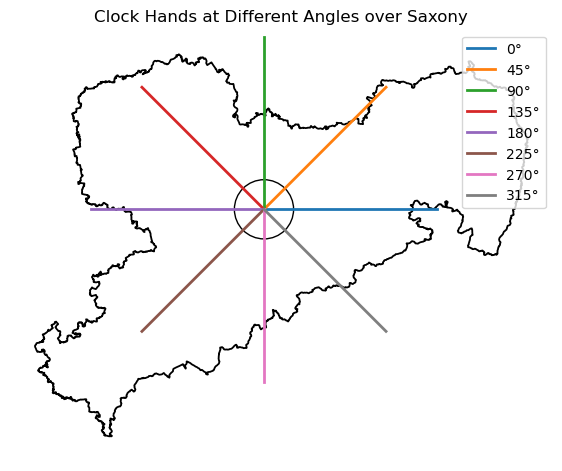

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import geopandas as gpd

# --- Assumptions ---
# You already have a GeoDataFrame called `saxony`

# Reproject Saxony to metric CRS for consistent distances
target_crs = "EPSG:3035"
saxony_m = saxony.to_crs(target_crs)
geom = saxony_m.geometry.unary_union

# Clock center
cx, cy = geom.centroid.x, geom.centroid.y
minx, miny, maxx, maxy = geom.bounds
extent = max(maxx - minx, maxy - miny)

# Hand length & clock face radius
hand_len = 0.35 * extent
face_radius = 0.06 * extent

# Example angles (degrees, like a clock: 0° = east, 90° = north, 180° = west, etc.)
angles_deg = [0, 45, 90, 135, 180, 225, 270, 315]

fig, ax = plt.subplots(figsize=(7, 7))
saxony_m.boundary.plot(ax=ax, linewidth=1.3, edgecolor="black")

# Draw the clock face
ax.add_patch(Circle((cx, cy), face_radius, fill=False, linewidth=1.0))

# Draw hands
for angle_deg in angles_deg:
    theta = np.deg2rad(angle_deg)
    x2 = cx + hand_len * np.cos(theta)
    y2 = cy + hand_len * np.sin(theta)
    ax.plot([cx, x2], [cy, y2], linewidth=2.0, label=f"{angle_deg}°")

ax.set_aspect("equal")
ax.set_xlim(minx - 0.05*extent, maxx + 0.05*extent)
ax.set_ylim(miny - 0.05*extent, maxy + 0.05*extent)
ax.set_title("Clock Hands at Different Angles over Saxony")
ax.axis("off")
ax.legend(loc="upper right")

plt.savefig("saxony_clock_multiple.png", dpi=300, bbox_inches="tight")
plt.show()
